In [15]:
%matplotlib inline
import matplotlib, qiskit, pprint
from matplotlib import pyplot as plt
import numpy as np
from numpy import pi
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, IBMQ, transpile, schedule, assemble
from qiskit.providers.aer import QasmSimulator
from qiskit.test.mock import FakeAlmaden, FakeMelbourne
 
# load account
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# simulators:
f_alma = FakeAlmaden() # simulator f_alma for pulse schedules
f_mel = FakeMelbourne() # simulator f_mel for simulator backend mel
qasm_simulator = Aer.get_backend('qasm_simulator') 

ibmqfactory.load_account:WARNING:2021-05-14 16:16:38,458: Credentials are already in use. The existing account in the session will be replaced.


# Deterministic Scrambling Circuit

Reference: Verified Quantum Information Scrambling https://arxiv.org/abs/1806.02807

![Determ1](.\\pics\\Determ1_Scrambling_Circ.jpg)


Matrix:
![Determ4](.\\pics\\Determ4_Scrambling_Circ.jpg)


Unitary:
![Determ2](.\\pics\\Determ2_Scrambling_Circ.jpg)


## General Functions:

In [4]:
# func to apply CZ and H gate unitary to upper or lower part of the circuit

def make_3q_U(circ,half):
    
    circ.cz(half[0],half[2])
    circ.cz(half[1],half[2])
    circ.cz(half[0],half[1])
    
    circ.barrier(half)
    
    for i in half:
        circ.h(i)
        
    circ.cz(half[0],half[2])
    circ.cz(half[0],half[1])
    circ.cz(half[1],half[2])

In [5]:
# funcs for bell pair entanglement and measurement

def entangle_bell_pairs(circ, bell_pairs):
    # Define many-body-system bell pairs
    for pair in bell_pairs:
        circ.h(pair[0])
        circ.cx(pair[0],pair[1])

def disentangle_bell_pair(circ, pair):
    circ.cx(pair[0], pair[1])
    circ.h(pair[0])

In [6]:
# func to return thet for Z rotation from Unitary parameter alpha

def get_theta_from_alpha(alpha):
    return (alpha*pi)/2

In [7]:
# find initial bell pairs for n qubit circ

def get_bell_pairs(circ):

    n = len(circ.qubits)
    # make pairings:
    if n%2 != 0:
        initalsys = [x for x in range(n)][1:-1] # put first and last qubits aside for initial entanglement of the system
        pairs = [[item,initalsys[int(len(initalsys)/2):][number]]
                         for (number,item) in enumerate(reversed(initalsys[:int(len(initalsys)/2)]))]
    else:
        print("Find out how to deal with even number circ, Hannah!")
    # append pair bob and q before bob:   
    pairs.append([n-2, n-1]) 
    
    return pairs

In [8]:
# func to get structure of scrambling U and U* for n qubit circ

def get_unitary_pairs(circ):
    
    if n%2 != 0:
        upper_qs = [x for x in range(n-1)][:int(n/2)]
        lower_qs = [x for x in range(n-1)][int(n/2):]
    else:
        print("Find out how to deal with even number circ, Hannah!")
    
    upper_pairs = sorted([(upper_qs[i],upper_qs[i+1]) 
                   for i in range(len(upper_qs)-1)] + [(upper_qs[i],upper_qs[i+2]) 
                                                       for i in range(len(upper_qs)-2)])

    lower_pairs = sorted([(lower_qs[i],lower_qs[i+1]) 
                   for i in range(len(lower_qs)-1)] + [(lower_qs[i],lower_qs[i+2]) 
                                                       for i in range(len(lower_qs)-2)])
    
    lower_pairs = [x for x in reversed(lower_pairs)]
    
    return upper_pairs, lower_pairs

In [9]:
# func to insert bell meas into circ

def insert_bell_measurement(circ, pair):
    circ.barrier()
    circ.cx(pair[0],pair[1])
    circ.h(pair[0])
    circ.measure(pair[0],pair[0])
    circ.measure(pair[1],pair[1])
    circ.barrier()

# Tests:

### A) 7 Qubit Circuit with U and U*


 Fidelity Bob Qubit: 	50.0%

 Fidelity Bob Partner: 	45.72%

 Fidelity Base Meas A: 	44.76%

 Fidelity Base Meas B: 	53.94%
{'0000000': 708,
 '0000100': 548,
 '0001000': 833,
 '0001100': 660,
 '0100000': 582,
 '0100100': 460,
 '0101000': 660,
 '0101100': 549,
 '1000000': 697,
 '1000100': 557,
 '1001000': 769,
 '1001100': 656,
 '1100000': 568,
 '1100100': 486,
 '1101000': 707,
 '1101100': 560}


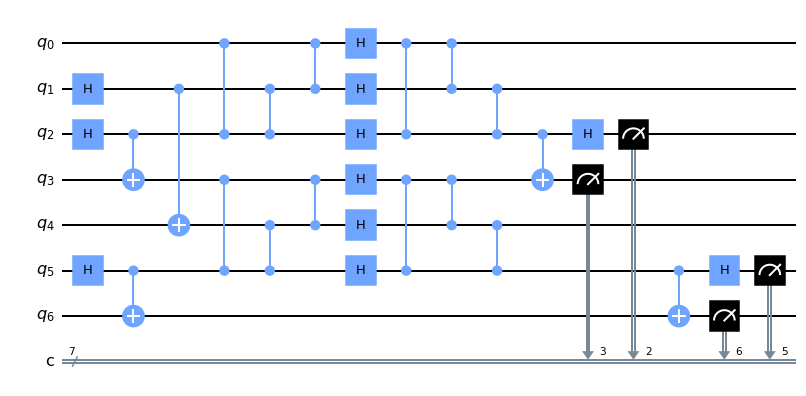

In [21]:
########################### circuit and structure #########################

# set number of qubits
n = 7

# circ 
circ = QuantumCircuit(n,n)
# structure 
upper_qs = [x for x in range(n-1)][:int(n/2)]
lower_qs = [x for x in range(n-1)][int(n/2):]  
bell_pairs = get_bell_pairs(circ)
# pairs for mesurements
basemeas = bell_pairs[0]
bob_pair = bell_pairs[-1]
# inums for results
meas_a_i, meas_b_i = -1 * (basemeas[0]+1), -1 * (basemeas[1]+1)
bob_imeas, bob_pmeas = 0,1

########################### apply protocol ################################

# 1. entangle EPR pairs
entangle_bell_pairs(circ, bell_pairs)
circ.barrier()

# 2. apply U and U* to both halfs of the circuit
make_3q_U(circ, upper_qs)
make_3q_U(circ, lower_qs)

# 3. measure base EPR pair 
insert_bell_measurement(circ,basemeas)

# 4. measure Bob paair
insert_bell_measurement(circ,bob_pair)

########################### run simulation ################################

# run on f_mel
pct = 100
shots = 100*pct
qobj = assemble(circ, shots=shots)
result = f_alma.run(qobj).result().get_counts()

############################ see results ##################################

bob_meas_1  = sum([v for (k,v) in result.items() if k[bob_imeas]=="1"])
bob_p_meas_1 = sum([v for (k,v) in result.items() if k[bob_pmeas]=="1"])
meas1_1 = sum([v for (k,v) in result.items() if k[meas_a_i]=="1"])
meas2_1 =  sum([v for (k,v) in result.items() if k[meas_b_i]=="1"])

print("\n Fidelity Bob Qubit: \t{}%".format(bob_meas_1/pct)) 
print("\n Fidelity Bob Partner: \t{}%".format(bob_p_meas_1/pct)) 
print("\n Fidelity Base Meas A: \t{}%".format(meas1_1/pct)) 
print("\n Fidelity Base Meas B: \t{}%".format(meas2_1/pct)) 
pprint.pprint(result)

############################ see circuit ##################################

circ.draw('mpl', plot_barriers=False)

### B) 7 Qubit Circuit with U, U* and U'



 Fidelity Bob Qubit: 	6.4%

 Fidelity Bob Partner: 	2.34%

 Fidelity Base Meas A: 	45.3%

 Fidelity Base Meas B: 	53.75%
{'0000000': 2319,
 '0000100': 1910,
 '0001000': 2718,
 '0001100': 2246,
 '0100000': 50,
 '0100100': 47,
 '0101000': 37,
 '0101100': 33,
 '1000000': 149,
 '1000100': 121,
 '1001000': 164,
 '1001100': 139,
 '1100000': 15,
 '1100100': 14,
 '1101000': 18,
 '1101100': 20}


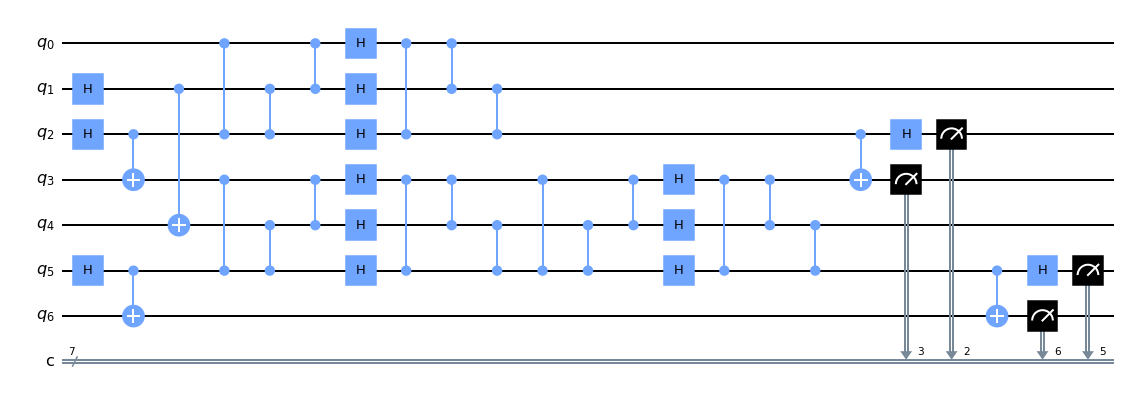

In [25]:
########################### circuit and structure #########################

# set number of qubits
n = 7

# circ 
circ = QuantumCircuit(n,n)
# structure 
upper_qs = [x for x in range(n-1)][:int(n/2)]
lower_qs = [x for x in range(n-1)][int(n/2):]  
bell_pairs = get_bell_pairs(circ)
# pairs for mesurements
basemeas = bell_pairs[0]
bob_pair = bell_pairs[-1]
# inums for results
meas_a_i, meas_b_i = -1 * (basemeas[0]+1), -1 * (basemeas[1]+1)
bob_imeas, bob_pmeas = 0,1

########################### apply protocol ################################

# 1. entangle EPR pairs
entangle_bell_pairs(circ, bell_pairs)
circ.barrier()

# 2. apply U, U* and U' to both halfs of the circuit
make_3q_U(circ, upper_qs) # U
make_3q_U(circ, lower_qs) # U*
make_3q_U(circ, lower_qs) # U'

# 3. measure base EPR pair 
insert_bell_measurement(circ,basemeas)

# 4. measure Bob paair
insert_bell_measurement(circ,bob_pair)

########################### run simulation ################################

# run on f_mel
pct = 100
shots = 100*pct
qobj = assemble(circ, shots=shots)
result = f_alma.run(qobj).result().get_counts()

############################ see results ##################################

bob_meas_1  = sum([v for (k,v) in result.items() if k[bob_imeas]=="1"])
bob_p_meas_1 = sum([v for (k,v) in result.items() if k[bob_pmeas]=="1"])
meas1_1 = sum([v for (k,v) in result.items() if k[meas_a_i]=="1"])
meas2_1 =  sum([v for (k,v) in result.items() if k[meas_b_i]=="1"])

print("\n Fidelity Bob Qubit: \t{}%".format(bob_meas_1/pct)) 
print("\n Fidelity Bob Partner: \t{}%".format(bob_p_meas_1/pct)) 
print("\n Fidelity Base Meas A: \t{}%".format(meas1_1/pct)) 
print("\n Fidelity Base Meas B: \t{}%".format(meas2_1/pct)) 
pprint.pprint(result)

############################ see circuit ##################################

circ.draw('mpl', plot_barriers=False)